In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import scipy as sp
from sklearn.cluster import KMeans
from sklearn import linear_model
import pandas as pd

In [2]:
def Azose_Raftery_Decomposition(FlowsK):
    Return = [np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4))]
    Emigration = [np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4))]
    
    for j in range(0,3):
        for i in range(0,4):
            Return[j].T[i] = FlowsK[i][j].T[i]
            # columns correspond to country of birth
            Emigration[j][i] = FlowsK[i][j][i]
            # rows correspond to country of birth
    
    return Emigration, Return

def StocksAndFlows(stock0, LXt2k, Pt2k, Pt3k,K):
    St1k = np.random.multinomial(1000, LXt2k)
    Ft1k = np.zeros((4,4))
    Ft1k[K] = St1k

    St2k = np.zeros(4)
    Ft2k = np.zeros((4,4))

    for j in range(0,4): 
        Ft2k[j] = np.random.multinomial(St1k[j], Pt2k[j])
    for k in range(0,4):
        St2k[k] = sum(Ft2k.T[k])
    St3k = np.zeros(4)
    Ft3k = np.zeros((4,4))

    for j in range(0,4):
        Ft3k[j] = np.random.multinomial(St2k[j], Pt3k[j])
    for k in range(0,4):
        St3k[k] = sum(Ft3k.T[k])

    return St1k,St2k,St3k,Ft1k,Ft2k,Ft3k
    
def EmigAndReturnHat(St0,St1,St2,St3):
    # Compute Differences and Remove Diagonals:
    Dt1 = St1 - St0 - np.diag(np.diagonal(St1 - St0))
    Dt2 = St2 - St1 - np.diag(np.diagonal(St2 - St1))
    Dt3 = St3 - St2 - np.diag(np.diagonal(St3 - St2))
    # Keep Positive Differences
    EmigHat = [np.where(Dt1 > 0, Dt1, 0), np.where(Dt2 > 0, Dt2, 0),
               np.where(Dt3 > 0, Dt3, 0)]

    ReturnHat = [np.where(Dt1 < 0, np.abs(Dt1), 0).T, np.where(Dt2 < 0, np.abs(Dt2), 0).T,
                np.where(Dt3 < 0, np.abs(Dt3), 0).T]

    TotalFlowsHat = [np.where(Dt1 > 0, Dt1, 0) + np.where(Dt1 < 0, np.abs(Dt1), 0).T,
                    np.where(Dt2 > 0, Dt2, 0) + np.where(Dt2 < 0, np.abs(Dt2), 0).T,
                    np.where(Dt3 > 0, Dt3, 0) + np.where(Dt3 < 0, np.abs(Dt3), 0).T]

    return EmigHat, ReturnHat, TotalFlowsHat
    
def Error_Estimation(EmigHat,ReturnHat, Emigration, Return, TotalFlowsHat, flows):

    Error_Emig = []
    Error_Return = []
    Error_Total = []

    for i in range(0,3):
        Error_Emig.append(EmigHat[i] - Emigration[i])
        Error_Return.append(ReturnHat[i] - Return[i])
        Error_Total.append(TotalFlowsHat[i] - flows[i])
    return Error_Emig[0],Error_Emig[1],Error_Emig[2],Error_Return[0],Error_Return[1],Error_Return[2],Error_Total[0],Error_Total[1], Error_Total[2]
    
def Mean_Errors(TEEMt1,TEEMt2,TEEMt3,TERt1,TERt2,TERt3,T):
    Mean_TEEMt1 = TEEMt1/T
    Mean_TEEMt2 = TEEMt2/T
    Mean_TEEMt3 = TEEMt3/T
    Mean_TERt1 = TERt1/T
    Mean_TERt2 = TERt2/T
    Mean_TERt3 = TERt3/T
    return Mean_TEEMt1, Mean_TEEMt2, Mean_TEEMt3, Mean_TERt1, Mean_TERt2, Mean_TERt3
    
def Mean_Errors2(TFERt1,TFERt2,TFERt3,T):
    Mean_TFERt1 = TFERt1/T
    Mean_TFERt2 = TFERt2/T
    Mean_TFERt3 = TFERt3/T
    return Mean_TFERt1, Mean_TFERt2, Mean_TFERt3


def DecompErrorData(EmigHat, ReturnHat, i,j,Ft1A,Ft2A,Ft3A,Ft1B,Ft2B,Ft3B,Ft1C,Ft2C,Ft3C,Ft1D,Ft2D,Ft3D, Transit):
    FlowsA = [Ft1A - np.diag(np.diagonal(Ft1A)), Ft2A - np.diag(np.diagonal(Ft2A)), Ft3A - np.diag(np.diagonal(Ft3A))]
    FlowsB = [Ft1B - np.diag(np.diagonal(Ft1B)), Ft2B - np.diag(np.diagonal(Ft2B)), Ft3B - np.diag(np.diagonal(Ft3B))]
    FlowsC = [Ft1C - np.diag(np.diagonal(Ft1C)), Ft2C - np.diag(np.diagonal(Ft2C)), Ft3C - np.diag(np.diagonal(Ft3C))]
    FlowsD = [Ft1D - np.diag(np.diagonal(Ft1D)), Ft2D - np.diag(np.diagonal(Ft2D)), Ft3D - np.diag(np.diagonal(Ft3D))]
    FlowsK = [FlowsA, FlowsB, FlowsC, FlowsD]
    TotalFlows = [FlowsA[0] + FlowsB[0] + FlowsC[0] + FlowsD[0],
                 FlowsA[1] + FlowsB[1] + FlowsC[1] + FlowsD[1],
                 FlowsA[2] + FlowsB[2] + FlowsC[2] + FlowsD[2]]
    Emigration, Return = Azose_Raftery_Decomposition(FlowsK)
    #error decomposition of total flow
    ErrEmig = np.zeros((1,3))
    ErrRet = np.zeros((1,3))
    ErrEmigInv = np.zeros((1,3))
    ErrRetInv = np.zeros((1,3))
    ErrTrk = np.zeros((1,3))
    ErrTri = np.zeros((1,3))
    ErrTrj = np.zeros((1,3))
    E = np.zeros(3)
    R = np.zeros(3)
    # filling the error decomposition
    for t in range(0,3):
        # fill Decomp depending on the value of the estimation R^ and E^
        if ReturnHat[t][i][j] == 0 and EmigHat[t][i][j] == 0:
            ErrEmig[0][t] += -Emigration[t][i][j] # emigration of people born in i leaving to j between t and t+1
            ErrRet[0][t] += -Return[t][i][j] # return of people born in j going from i to j between t and t+1
            R[t] = 0
            E[t] = 0
        if ReturnHat[t][i][j] != 0 and EmigHat[t][i][j] == 0:
            ErrEmig[0][t] += -Emigration[t][i][j] # emigration of people born in i leaving to j between t and t+1
            ErrEmigInv[0][t] += -Emigration[t][j][i] # emigration of people born in j leaving to i between t and t+1
            ErrTrj[0][t] += -(sum(FlowsK[j][t].T[i]) - sum(FlowsK[j][t][i]) - Emigration[t][j][i] + Return[t][i][j])
            R[t] = 1
            E[t] = 0
        if ReturnHat[t][i][j] == 0 and EmigHat[t][i][j] != 0:
            ErrRet[0][t] += -Return[t][i][j]
            ErrRetInv[0][t] += -Return[t][j][i]
            ErrTri[0][t] += -(sum(FlowsK[i][t][j]) - sum(FlowsK[i][t].T[j]) + Emigration[t][i][j] - Return[t][j][i])
            R[t] = 0
            E[t] = 1
        if ReturnHat[t][i][j] != 0 and EmigHat[t][i][j] != 0:
            ErrEmigInv[0][t] += -Emigration[t][j][i]
            ErrRetInv[0][t] += -Return[t][j][i]
            ErrTri[0][t] += -(sum(FlowsK[i][t][j]) - sum(FlowsK[i][t].T[j]) + Emigration[t][i][j] - Return[t][j][i])
            ErrTrj[0][t] += -(sum(FlowsK[j][t].T[i]) - sum(FlowsK[j][t][i]) - Emigration[t][j][i] + Return[t][i][j])
            R[t] = 1
            E[t] = 1
        for p in range(0,4):
                if p != i and p !=j:
                    ErrTrk[0][t] += -FlowsK[p][t][i][j] # adding transit errors of people neither born in i or j
    return ErrEmig,ErrRet,ErrEmigInv,ErrRetInv,ErrTrk,ErrTri,ErrTrj,E,R

def TrueFlows(St1,St2,St3,St4,Pt):
    St = [St1,St2,St3,St4]
    Ft = [[],[],[]]
    for i in range(0,3):
        for j in range(0,4):
            Ft[i].append(np.matmul(np.diag(St[i][j]),Pt[i][j]))

    return Ft[0][0], Ft[1][0], Ft[2][0], Ft[0][1], Ft[1][1], Ft[2][1],Ft[0][2], Ft[1][2], Ft[2][2],Ft[0][3], Ft[1][3], Ft[2][3]

def Margins(I,Pt):
    LXt = [I,[],[],[]]
    for i in range(0,3):
        for j in range(0,4):
            LXt[i+1].append(np.dot(LXt[i][j],Pt[i][j]))
    return LXt, LXt[1][0], LXt[1][1], LXt[1][2], LXt[1][3], LXt[2][0], LXt[2][1], LXt[2][2], LXt[2][3], LXt[3][0], LXt[3][1], LXt[3][2], LXt[3][3]

def TrueStocks(N,M):
    St = [[],[],[],[]]
    for i in range(0,4):
        for j in range(0,4):
            St[i].append(N*M[i][j])
            # We have:
    #St1 = [St1A, St1B, St1C, St1D]
    #St2 = [St2A, St2B, St2C, St2D]
    #St3 = [St3A, St3B, St3C, St3D]
    #St4 = [St4A, St4B, St4C, St4D]
    return St[0], St[1], St[2], St[3]

Scenario 1 with transits, war, cultural tipping point

In [5]:
Pt1A = np.array([[0.98, 0.01, 0.01, 0], [0,0,0,0], [0,0,0,0], [0,0,0,0]])
Pt1B = np.array([[0,0,0,0], [0.09, 0.9, 0.005, 0.005], [0,0,0,0], [0,0,0,0]])
Pt1C = np.array([[0,0,0,0], [0,0,0,0], [0.03, 0.005, 0.95, 0.015], [0,0,0,0]])
Pt1D = np.array([[0,0,0,0], [0,0,0,0], [0,0,0,0], [0.025, 0.005, 0.03, 0.94]])

Pt2A = np.array([[0.98, 0.01, 0.01, 0], [0.40,0.58,0.02,0], [0.40,0.02,0.58,0], [1,0,0,0]])
Pt2B = np.array([[0.90,0.08,0.02,0], [0.09, 0.905, 0.005, 0], [0.02,0.08,0.90,0], [0,1,0,0]])
Pt2C = np.array([[0.40,0.02,0.58,0], [0.02,0.4,0.58,0], [0.03, 0.005, 0.965, 0], [0,0,1,0]])
Pt2D = np.array([[0.7,0.15,0.15,0], [0.15,0.7,0.15,0], [0.15,0.15,0.7,0], [0.075, 0.025, 0.2, 0.7]])

Pt3A = np.array([[0.98, 0.01, 0.01, 0], [0.40,0.58,0.02,0], [0.40,0.02,0.58,0], [1,0,0,0]])
Pt3B = np.array([[0.8,0.18,0.02,0], [0.015, 0.98, 0.005, 0], [0.02,0.18,0.8,0], [0,1,0,0]])
Pt3C = np.array([[0.40,0.02,0.58,0], [0.02,0.4,0.58,0], [0.03, 0.005, 0.965, 0], [0,0,1,0]])
Pt3D = np.array([[0.7,0.15,0.15,0], [0.15,0.7,0.15,0], [0.15,0.15,0.7,0], [0.075, 0.025, 0.2, 0.7]])

In [4]:
Pt1A = np.array([[0.98, 0.01, 0.01, 0], [0,0,0,0], [0,0,0,0], [0,0,0,0]])
Pt1B = np.array([[0,0,0,0], [0.09, 0.9, 0.005, 0.005], [0,0,0,0], [0,0,0,0]])
Pt1C = np.array([[0,0,0,0], [0,0,0,0], [0.03, 0.005, 0.95, 0.015], [0,0,0,0]])
Pt1D = np.array([[0,0,0,0], [0,0,0,0], [0,0,0,0], [0.025, 0.005, 0.03, 0.94]])

Pt2A = np.array([[0.98, 0.01, 0.01, 0], [0.40,0.58,0.02,0], [0.40,0.02,0.58,0], [1,0,0,0]])
Pt2B = np.array([[0.90,0.08,0.02,0], [0.09, 0.905, 0.005, 0], [0.02,0.08,0.90,0], [0,1,0,0]])
Pt2C = np.array([[0.40,0.02,0.58,0], [0.02,0.4,0.58,0], [0.03, 0.005, 0.965, 0], [0,0,1,0]])
Pt2D = np.array([[0.7,0.15,0.15,0], [0.15,0.7,0.15,0], [0.15,0.15,0.7,0], [0.075, 0.025, 0.2, 0.7]])

Pt3A = np.array([[0.98, 0.01, 0.01, 0], [0.40,0.58,0.02,0], [0.40,0.02,0.58,0], [1,0,0,0]])
Pt3B = np.array([[0.8,0.18,0.02,0], [0.015, 0.98, 0.005, 0], [0.02,0.18,0.8,0], [0,1,0,0]])
Pt3C = np.array([[0.40,0.02,0.58,0], [0.02,0.4,0.58,0], [0.03, 0.005, 0.965, 0], [0,0,1,0]])
Pt3D = np.array([[0.95,0.025,0.025,0], [0.025,0.95,0.025,0], [0.025,0.025,0.95,0], [0.075, 0.025, 0.2, 0.7]])

In [6]:
I_A = np.array([1,0,0,0])
I_B = np.array([0,1,0,0])
I_C = np.array([0,0,1,0])
I_D = np.array([0,0,0,1])
I = [I_A,I_B,I_C,I_D]
Pt = [[Pt1A,Pt1B,Pt1C,Pt1D],
     [Pt2A,Pt2B,Pt2C,Pt2D],
     [Pt3A,Pt3B,Pt3C,Pt3D]]
LXt, LXt2A,LXt2B,LXt2C,LXt2D,LXt3A,LXt3B,LXt3C,LXt3D,LXt4A,LXt4B,LXt4C,LXt4D = Margins(I,Pt)

Simulated Flows

In [7]:
# Simulation to obtain all flows
T = 20000 # total of simulations
Error_Emig = [np.zeros((4,4)),np.zeros((4,4)),np.zeros((4,4))]
Return_Emig = [np.zeros((4,4)),np.zeros((4,4)),np.zeros((4,4))]
TEEMt1, TEEMt2, TEEMt3, TERt1, TERt2, TERt3 = np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4))
TSEEMt1, TSEEMt2, TSEEMt3, TSERt1, TSERt2, TSERt3 = np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4))
TFERt1, TFERt2, TFERt3,TSFERt1, TSFERt2, TSFERt3 = np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4)),np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4))
Temighat, Treturnhat = np.zeros((4,4)), np.zeros((4,4))
for t in range(0,T):
    # Sub-population A
    St0A = np.array([1000,0,0,0])
    St1A,St2A,St3A,Ft1A,Ft2A,Ft3A = StocksAndFlows(St0A, LXt2A,Pt2A,Pt3A,0)
    
    # Sub-population B
    St0B = np.array([0,1000,0,0])
    St1B,St2B,St3B,Ft1B,Ft2B,Ft3B = StocksAndFlows(St0B, LXt2B,Pt2B,Pt3B,1)

    # Sub-population C
    St0C = np.array([0,0,1000,0])
    St1C,St2C,St3C,Ft1C,Ft2C,Ft3C = StocksAndFlows(St0C, LXt2C,Pt2C,Pt3C,2)

    # Sub-population D
    St0D = np.array([0,0,0,1000])
    St1D,St2D,St3D,Ft1D,Ft2D,Ft3D = StocksAndFlows(St0D, LXt2D,Pt2D,Pt3D,3)
        
    # Get back the Emigration and Return Flows
    FlowsA = [Ft1A - np.diag(np.diagonal(Ft1A)), Ft2A - np.diag(np.diagonal(Ft2A)), Ft3A - np.diag(np.diagonal(Ft3A))]
    FlowsB = [Ft1B - np.diag(np.diagonal(Ft1B)), Ft2B - np.diag(np.diagonal(Ft2B)), Ft3B - np.diag(np.diagonal(Ft3B))]
    FlowsC = [Ft1C - np.diag(np.diagonal(Ft1C)), Ft2C - np.diag(np.diagonal(Ft2C)), Ft3C - np.diag(np.diagonal(Ft3C))]
    FlowsD = [Ft1D - np.diag(np.diagonal(Ft1D)), Ft2D - np.diag(np.diagonal(Ft2D)), Ft3D - np.diag(np.diagonal(Ft3D))]
    FlowsK = [FlowsA, FlowsB, FlowsC, FlowsD]
    
    TotalFlows = [FlowsA[0] + FlowsB[0] + FlowsC[0] + FlowsD[0],
                 FlowsA[1] + FlowsB[1] + FlowsC[1] + FlowsD[1],
                 FlowsA[2] + FlowsB[2] + FlowsC[2] + FlowsD[2]]
    Emigration, Return = Azose_Raftery_Decomposition(FlowsK)
    # only useful for transit flows so it's fine...
    
    # Compute the Emigration and Return Estimates in a format to make
    # them comparable elementwise with True Emigration and True Return Matrices
    
    # Aggregate the stocks:
    St0 = np.array([St0A, St0B, St0C, St0D])
    St1 = np.array([St1A, St1B, St1C, St1D])
    St2 = np.array([St2A, St2B, St2C, St2D])
    St3 = np.array([St3A, St3B, St3C, St3D])

    EmigHat, ReturnHat, TotalFlowsHat = EmigAndReturnHat(St0,St1,St2,St3)
    
    # Compute the error of estimation of emigration flows and return
    # flows period per period, country of birth per country of birth
    # take this value... look at the mean when n -> plus infinity
    EEMt1,EEMt2,EEMt3,ERt1,ERt2,ERt3,FERt1,FERt2,FERt3 = Error_Estimation(EmigHat,ReturnHat, Emigration, Return, TotalFlowsHat, TotalFlows)
    TEEMt1 += EEMt1
    TEEMt2 += EEMt2
    TEEMt3 += EEMt3
    TERt1 += ERt1
    TERt2 += ERt2
    TERt3 += ERt3
    TSEEMt1 += np.square(EEMt1)
    TSEEMt2 += np.square(EEMt2)
    TSEEMt3 += np.square(EEMt3)
    TSERt1 += np.square(ERt1)
    TSERt2 += np.square(ERt2)
    TSERt3 += np.square(ERt3)
    TFERt1 += FERt1
    TFERt2 += FERt2
    TFERt3 += FERt3
    TSFERt1 += np.square(FERt1)
    TSFERt2 += np.square(FERt2)
    TSFERt3 += np.square(FERt3)
    Temighat += EmigHat[2]
    Treturnhat += ReturnHat[2]

Mean_ReturnHat = (1/T)*Treturnhat
Mean_EmigHat = (1/T)*Temighat
Mean_TEEMt1, Mean_TEEMt2, Mean_TEEMt3, Mean_TERt1, Mean_TERt2, Mean_TERt3 = Mean_Errors(TEEMt1,TEEMt2,TEEMt3,TERt1,TERt2,TERt3,T)
Mean_TFERt1, Mean_TFERt2, Mean_TFERt3 = Mean_Errors2(TFERt1,TFERt2,TFERt3,T)
Mean2_TEEMt1, Mean2_TEEMt2, Mean2_TEEMt3, Mean2_TERt1, Mean2_TERt2, Mean2_TERt3 = Mean_Errors(TSEEMt1,TSEEMt2,TSEEMt3,TSERt1,TSERt2,TSERt3,T)
Mean2_TEEMt1, Mean2_TEEMt2, Mean2_TEEMt3, Mean2_TFERt1, Mean2_TFERt2, Mean2_TFERt3 = Mean_Errors(TSEEMt1,TSEEMt2,TSEEMt3,TSFERt1,TSFERt2,TSFERt3,T)
Var_EEMt1, Var_EEMt2, Var_EEMt3 = Mean2_TEEMt1 - np.square(Mean_TEEMt1), Mean2_TEEMt2 - np.square(Mean_TEEMt2), Mean2_TEEMt3 - np.square(Mean_TEEMt3)
Var_ERt1, Var_ERt2, Var_ERt3 = Mean2_TERt1 - np.square(Mean_TERt1), Mean2_TERt2 - np.square(Mean_TERt2), Mean2_TERt3 - np.square(Mean_TERt3)
Var_FERt1, Var_FERt2, Var_FERt3 = Mean2_TFERt1 - np.square(Mean_TFERt1), Mean2_TFERt2 - np.square(Mean_TFERt2), Mean2_TFERt3 - np.square(Mean_TFERt3)

Extension

In [24]:
P = Matrix((Pt3A-np.identity(4)).T)
P.nullspace()

[]

In [30]:
Matrix((Pt3A-np.identity(4)).T).nullspace()

[]

In [31]:
Pt3A

array([[0.98, 0.01, 0.01, 0.  ],
       [0.4 , 0.58, 0.02, 0.  ],
       [0.4 , 0.02, 0.58, 0.  ],
       [1.  , 0.  , 0.  , 0.  ]])

In [8]:
# Simulation to obtain all flows
T = 20000 # total of simulations
Error_Emig = [np.zeros((4,4)),np.zeros((4,4)),np.zeros((4,4))]
Return_Emig = [np.zeros((4,4)),np.zeros((4,4)),np.zeros((4,4))]
TEEMt1, TEEMt2, TEEMt3, TERt1, TERt2, TERt3 = np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4))
TSEEMt1, TSEEMt2, TSEEMt3, TSERt1, TSERt2, TSERt3 = np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4))
TFERt1, TFERt2, TFERt3,TSFERt1, TSFERt2, TSFERt3 = np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4)),np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4))
Temighat, Treturnhat = np.zeros((4,4)), np.zeros((4,4))
for t in range(0,T):
    # Sub-population A
    St0A = np.array([1000,0,0,0])
    St1A,St2A,St3A,Ft1A,Ft2A,Ft3A = StocksAndFlows(St0A, LXt2A,Pt2A,Pt3A,0)
    
    # Sub-population B
    St0B = np.array([0,1000,0,0])
    St1B,St2B,St3B,Ft1B,Ft2B,Ft3B = StocksAndFlows(St0B, LXt2B,Pt2B,Pt3B,1)

    # Sub-population C
    St0C = np.array([0,0,1000,0])
    St1C,St2C,St3C,Ft1C,Ft2C,Ft3C = StocksAndFlows(St0C, LXt2C,Pt2C,Pt3C,2)

    # Sub-population D
    St0D = np.array([0,0,0,1000])
    St1D,St2D,St3D,Ft1D,Ft2D,Ft3D = StocksAndFlows(St0D, LXt2D,Pt2D,Pt3D,3)
        
    # Get back the Emigration and Return Flows
    FlowsA = [Ft1A - np.diag(np.diagonal(Ft1A)), Ft2A - np.diag(np.diagonal(Ft2A)), Ft3A - np.diag(np.diagonal(Ft3A))]
    FlowsB = [Ft1B - np.diag(np.diagonal(Ft1B)), Ft2B - np.diag(np.diagonal(Ft2B)), Ft3B - np.diag(np.diagonal(Ft3B))]
    FlowsC = [Ft1C - np.diag(np.diagonal(Ft1C)), Ft2C - np.diag(np.diagonal(Ft2C)), Ft3C - np.diag(np.diagonal(Ft3C))]
    FlowsD = [Ft1D - np.diag(np.diagonal(Ft1D)), Ft2D - np.diag(np.diagonal(Ft2D)), Ft3D - np.diag(np.diagonal(Ft3D))]
    FlowsK = [FlowsA, FlowsB, FlowsC, FlowsD]
    
    TotalFlows = [FlowsA[0] + FlowsB[0] + FlowsC[0] + FlowsD[0],
                 FlowsA[1] + FlowsB[1] + FlowsC[1] + FlowsD[1],
                 FlowsA[2] + FlowsB[2] + FlowsC[2] + FlowsD[2]]
    Emigration, Return = Azose_Raftery_Decomposition(FlowsK)
    # only useful for transit flows so it's fine...
    
    # Compute the Emigration and Return Estimates in a format to make
    # them comparable elementwise with True Emigration and True Return Matrices
    
    # Aggregate the stocks:
    St0 = np.array([St0A, St0B, St0C, St0D])
    St1 = np.array([St1A, St1B, St1C, St1D])
    St2 = np.array([St2A, St2B, St2C, St2D])
    St3 = np.array([St3A, St3B, St3C, St3D])

    
    
    EmigHat, ReturnHat, TotalFlowsHat = EmigAndReturnHat(St0,St1,St2,St3)
    
    # Compute the error of estimation of emigration flows and return
    # flows period per period, country of birth per country of birth
    # take this value... look at the mean when n -> plus infinity
    EEMt1,EEMt2,EEMt3,ERt1,ERt2,ERt3,FERt1,FERt2,FERt3 = Error_Estimation(EmigHat,ReturnHat, Emigration, Return, TotalFlowsHat, TotalFlows)
    TEEMt1 += EEMt1
    TEEMt2 += EEMt2
    TEEMt3 += EEMt3
    TERt1 += ERt1
    TERt2 += ERt2
    TERt3 += ERt3
    TSEEMt1 += np.square(EEMt1)
    TSEEMt2 += np.square(EEMt2)
    TSEEMt3 += np.square(EEMt3)
    TSERt1 += np.square(ERt1)
    TSERt2 += np.square(ERt2)
    TSERt3 += np.square(ERt3)
    TFERt1 += FERt1
    TFERt2 += FERt2
    TFERt3 += FERt3
    TSFERt1 += np.square(FERt1)
    TSFERt2 += np.square(FERt2)
    TSFERt3 += np.square(FERt3)
    Temighat += EmigHat[2]
    Treturnhat += ReturnHat[2]
    #for n in range(0,100): # asymptotic bias
        #EEMt1,EEMt2,EEMt3,ERt1,ERt2,ERt3,FERt1,FERt2,FERt3 = Error_Estimation(EmigHat,ReturnHat, Emigration, Return, TotalFlowsHat, TotalFlows)    
        #TFERt3 += FERt3

Mean_ReturnHat = (1/T)*Treturnhat
Mean_EmigHat = (1/T)*Temighat
Mean_TEEMt1, Mean_TEEMt2, Mean_TEEMt3, Mean_TERt1, Mean_TERt2, Mean_TERt3 = Mean_Errors(TEEMt1,TEEMt2,TEEMt3,TERt1,TERt2,TERt3,T)
Mean_TFERt1, Mean_TFERt2, Mean_TFERt3 = Mean_Errors2(TFERt1,TFERt2,TFERt3,T)
Mean2_TEEMt1, Mean2_TEEMt2, Mean2_TEEMt3, Mean2_TERt1, Mean2_TERt2, Mean2_TERt3 = Mean_Errors(TSEEMt1,TSEEMt2,TSEEMt3,TSERt1,TSERt2,TSERt3,T)
Mean2_TEEMt1, Mean2_TEEMt2, Mean2_TEEMt3, Mean2_TFERt1, Mean2_TFERt2, Mean2_TFERt3 = Mean_Errors(TSEEMt1,TSEEMt2,TSEEMt3,TSFERt1,TSFERt2,TSFERt3,T)
Var_EEMt1, Var_EEMt2, Var_EEMt3 = Mean2_TEEMt1 - np.square(Mean_TEEMt1), Mean2_TEEMt2 - np.square(Mean_TEEMt2), Mean2_TEEMt3 - np.square(Mean_TEEMt3)
Var_ERt1, Var_ERt2, Var_ERt3 = Mean2_TERt1 - np.square(Mean_TERt1), Mean2_TERt2 - np.square(Mean_TERt2), Mean2_TERt3 - np.square(Mean_TERt3)
Var_FERt1, Var_FERt2, Var_FERt3 = Mean2_TFERt1 - np.square(Mean_TFERt1), Mean2_TFERt2 - np.square(Mean_TFERt2), Mean2_TFERt3 - np.square(Mean_TFERt3)

Theoretical Flows

In [14]:
St1, St2, St3, St4 = TrueStocks(1000,LXt)
Ft1A, Ft2A, Ft3A, Ft1B, Ft2B, Ft3B, Ft1C, Ft2C, Ft3C, Ft1D, Ft2D, Ft3D = TrueFlows(St1,St2,St3,St4,Pt)
Ft1 = Ft1A + Ft1B + Ft1C + Ft1D - np.diag(np.diagonal( Ft1A + Ft1B + Ft1C + Ft1D))
Ft2 = Ft2A + Ft2B + Ft2C + Ft2D - np.diag(np.diagonal( Ft2A + Ft2B + Ft2C + Ft2D))
Ft3 = Ft3A + Ft3B + Ft3C + Ft3D - np.diag(np.diagonal( Ft3A + Ft3B + Ft3C + Ft3D))

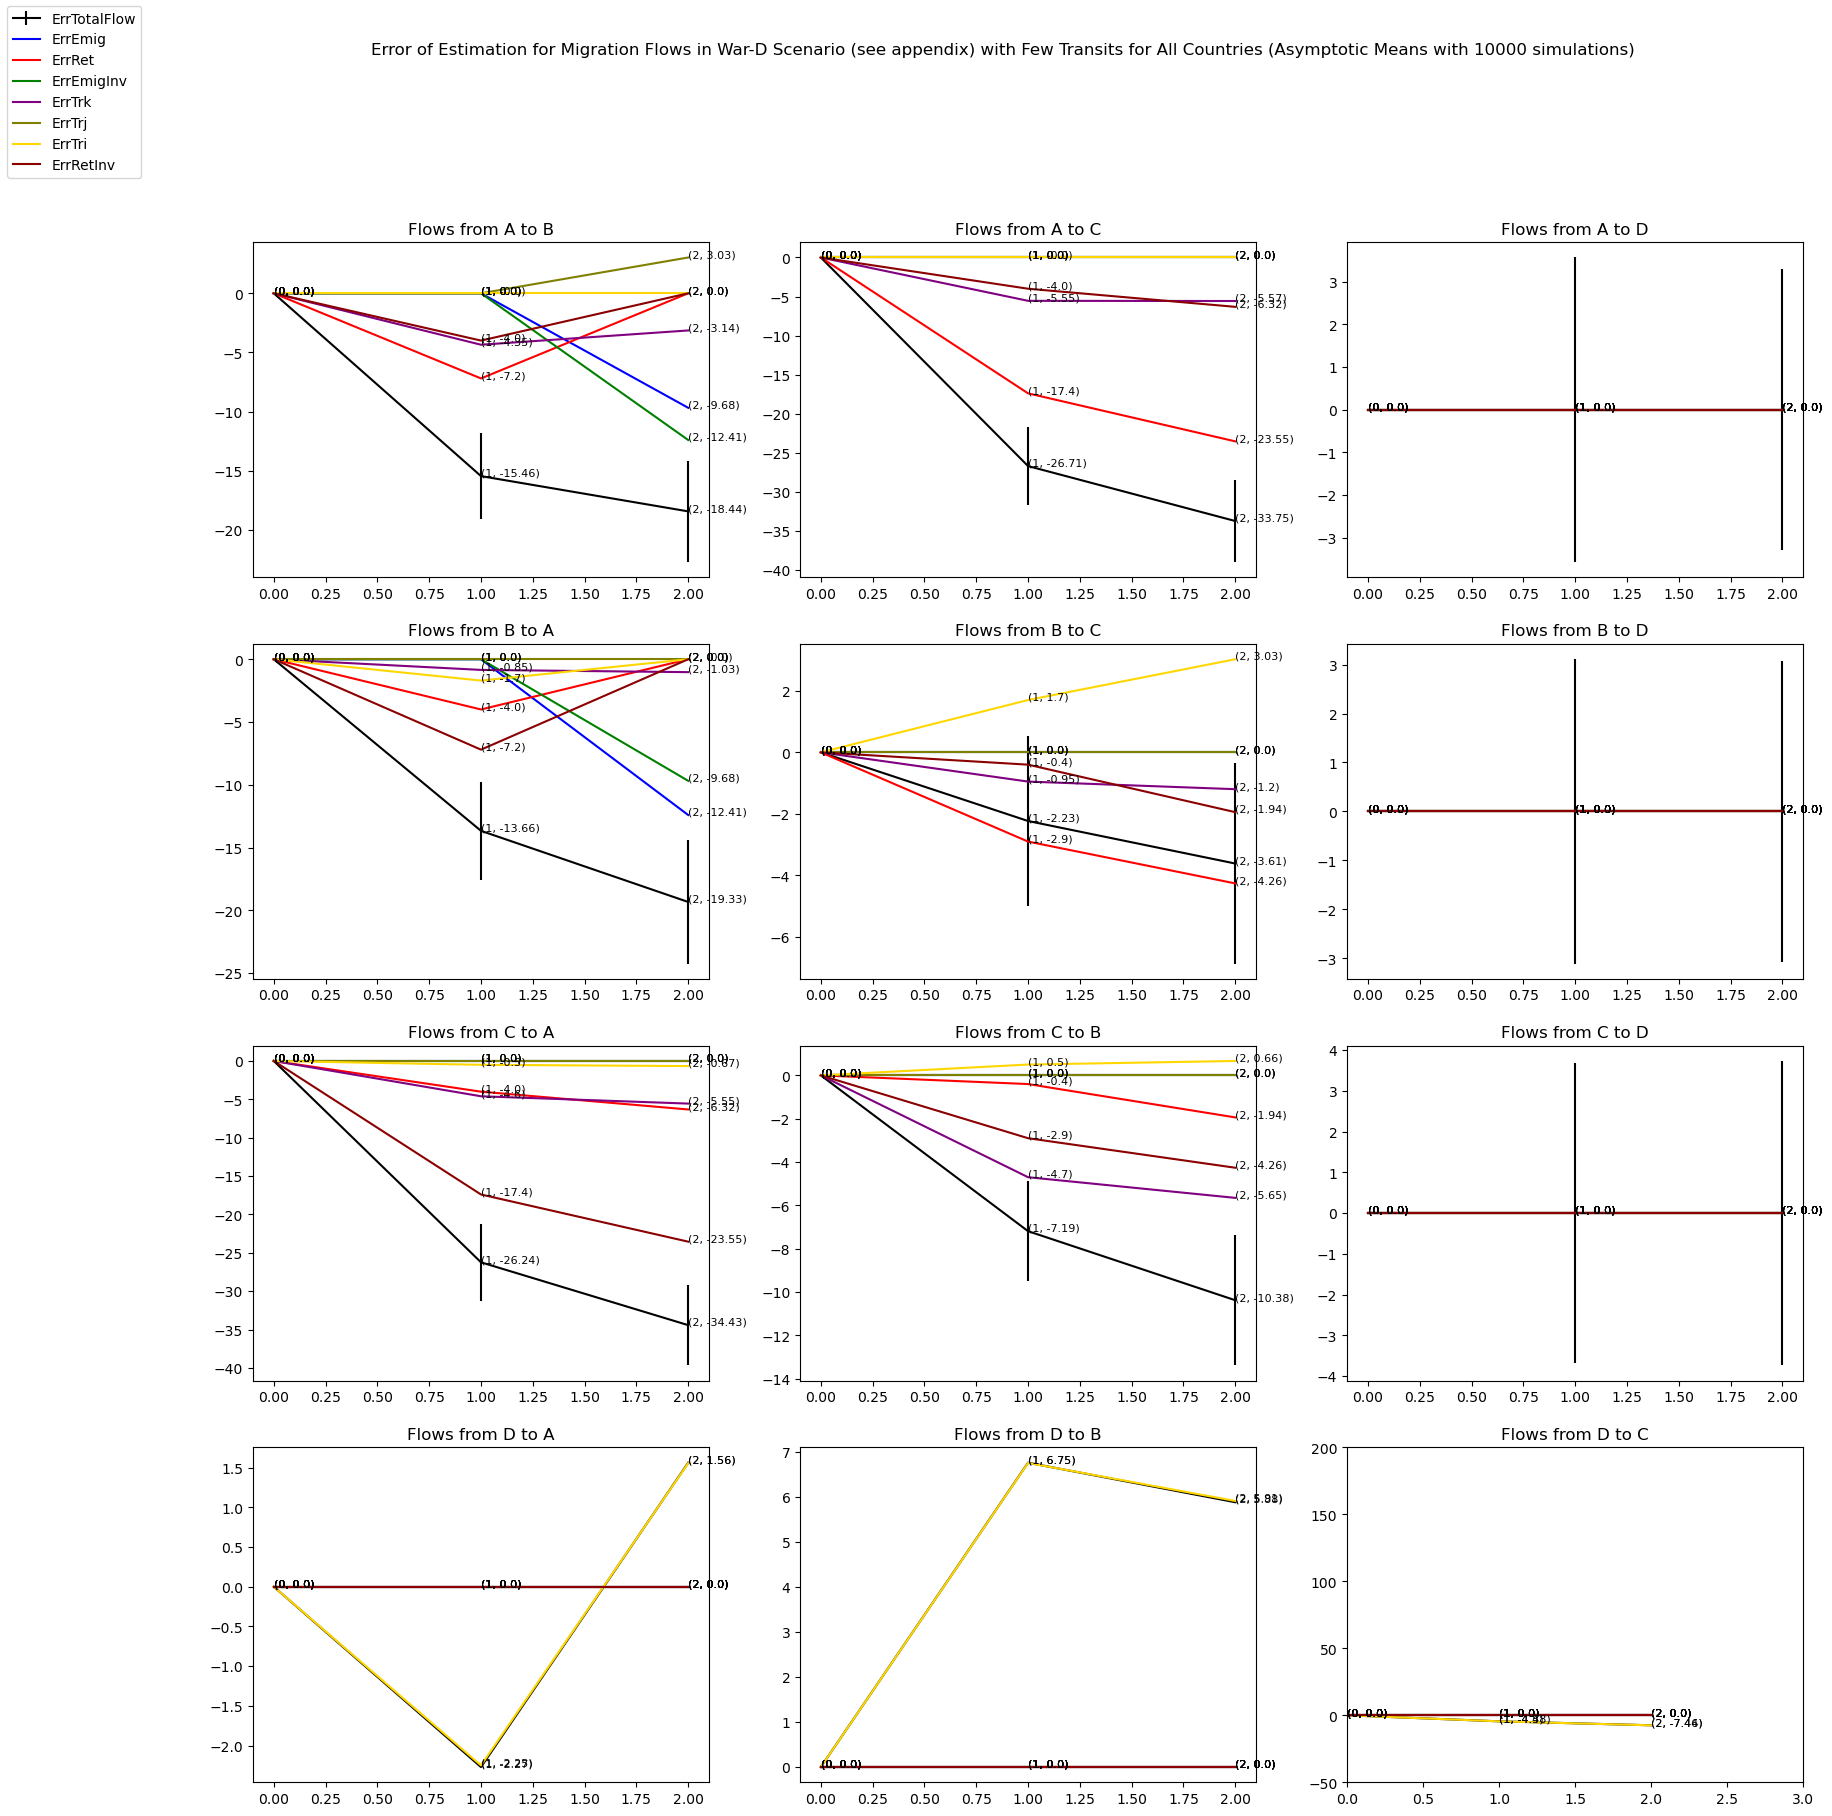

In [16]:
Data = np.zeros((36,11))
Data_Quanti = np.zeros((36,8))
MeanTF = [Mean_TFERt1, Mean_TFERt2, Mean_TFERt3]
FlowsA = [Ft1A - np.diag(np.diagonal(Ft1A)), Ft2A - np.diag(np.diagonal(Ft2A)), Ft3A - np.diag(np.diagonal(Ft3A))]
FlowsB = [Ft1B - np.diag(np.diagonal(Ft1B)), Ft2B - np.diag(np.diagonal(Ft2B)), Ft3B - np.diag(np.diagonal(Ft3B))]
FlowsC = [Ft1C - np.diag(np.diagonal(Ft1C)), Ft2C - np.diag(np.diagonal(Ft2C)), Ft3C - np.diag(np.diagonal(Ft3C))]
FlowsD = [Ft1D - np.diag(np.diagonal(Ft1D)), Ft2D - np.diag(np.diagonal(Ft2D)), Ft3D - np.diag(np.diagonal(Ft3D))]
FlowsK = [FlowsA, FlowsB, FlowsC, FlowsD]
TotalFlows = [FlowsA[0] + FlowsB[0] + FlowsC[0] + FlowsD[0],
             FlowsA[1] + FlowsB[1] + FlowsC[1] + FlowsD[1],
             FlowsA[2] + FlowsB[2] + FlowsC[2] + FlowsD[2]]
Emigration, Return = Azose_Raftery_Decomposition(FlowsK)
mycompletelist = []
mylistquanti = []
plt.rcParams["figure.figsize"] = [20, 20]
fig = plt.figure()
ax1 = fig.add_subplot(431)
ax2 = fig.add_subplot(432)
ax3 = fig.add_subplot(433)
ax4 = fig.add_subplot(434)
ax5 = fig.add_subplot(435)
ax6 = fig.add_subplot(436)
ax7 = fig.add_subplot(437)
ax8 = fig.add_subplot(438)
ax9 = fig.add_subplot(439)
ax10 = fig.add_subplot(4,3,10)
ax11 = fig.add_subplot(4,3,11)
ax12 = fig.add_subplot(4,3,12)
#ax4 = fig.add_subplot(224)
plt.ylim(-50, 200)
plt.xlim(0, 3)
B = [0, 1, 2]
k = 0
for i in range(0,4):
    for j in range(0,4):
        if i != j:
            ErrEmig,ErrRet,ErrEmigInv,ErrRetInv,ErrTrk,ErrTri,ErrTrj,E,R = DecompErrorData(EmigHat, ReturnHat, i,j,Ft1A,Ft2A,Ft3A,Ft1B,Ft2B,Ft3B,Ft1C,Ft2C,Ft3C,Ft1D,Ft2D,Ft3D,True)
            for t in range(0,3):
                mycompletelist.append(np.array([MeanTF[t][i][j],ErrEmig[0][t],ErrRet[0][t],ErrEmigInv[0][t],ErrRetInv[0][t],
                                       ErrTrk[0][t],ErrTri[0][t].round(decimals=2),ErrTrj[0][t], E[t], R[t],t]))
                mylistquanti.append(np.array([MeanTF[t][i][j],ErrEmig[0][t],ErrRet[0][t],ErrEmigInv[0][t],ErrRetInv[0][t],
                                       ErrTrk[0][t],ErrTri[0][t].round(decimals=2),ErrTrj[0][t]]))
            fig.axes[k].errorbar(B,[Mean_TFERt1[i][j], Mean_TFERt2[i][j], Mean_TFERt3[i][j]],yerr=[np.sqrt(Var_FERt1.T[i][j]), np.sqrt(Var_FERt2.T[i][j]), np.sqrt(Var_FERt3.T[i][j])],  color="black", label="ErrTotalFlow")
            
            for x, y in zip(B,[Mean_TFERt1[i][j].round(decimals=2), Mean_TFERt2[i][j].round(decimals=2), Mean_TFERt3[i][j].round(decimals=2)]):
                fig.axes[k].text(x, y, f"({x}, {y})", fontsize=8)
            fig.axes[k].errorbar(B, [ErrEmig[0][d] for d in range(0,3)], color = "blue",label="ErrEmig")
            for x, y in zip(B,[ErrEmig[0][d].round(decimals=2) for d in range(0,3)]):
                fig.axes[k].text(x, y, f"({x}, {y})", fontsize=8)
            fig.axes[k].errorbar(B, [ErrRet[0][d].round(decimals=2) for d in range(0,3)],color="red", label="ErrRet")
            for x, y in zip(B,[ErrRet[0][d].round(decimals=2) for d in range(0,3)]):
                fig.axes[k].text(x, y, f"({x}, {y})", fontsize=8)
            fig.axes[k].errorbar(B, [ErrEmigInv[0][d] for d in range(0,3)],color="green",label="ErrEmigInv")
            for x, y in zip(B,[ErrEmigInv[0][d].round(decimals=2) for d in range(0,3)]):
                fig.axes[k].text(x, y, f"({x}, {y})", fontsize=8)
            fig.axes[k].errorbar(B, [ErrTrk[0][d] for d in range(0,3)],color="purple",label="ErrTrk")
            for x, y in zip(B,[ErrTrk[0][d].round(decimals=2) for d in range(0,3)]):
                fig.axes[k].text(x, y, f"({x}, {y})", fontsize=8)
            fig.axes[k].errorbar(B, [ErrTrj[0][d] for d in range(0,3)],color="olive",label="ErrTrj")
            for x, y in zip(B,[ErrTrj[0][d].round(decimals=2) for d in range(0,3)]):
                fig.axes[k].text(x, y, f"({x}, {y})", fontsize=8)
            fig.axes[k].errorbar(B, [ErrTri[0][d] for d in range(0,3)],color="gold",label="ErrTri")
            for x, y in zip(B,[ErrTri[0][d].round(decimals=2) for d in range(0,3)]):
                fig.axes[k].text(x, y, f"({x}, {y})", fontsize=8)
            fig.axes[k].errorbar(B, [ErrRetInv[0][d] for d in range(0,3)],color="darkred",label="ErrRetInv")
            for x, y in zip(B,[ErrRetInv[0][d].round(decimals=2) for d in range(0,3)]):
                fig.axes[k].text(x, y, f"({x}, {y})", fontsize=8)
            
            k += 1 # next subplot

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = lines_labels[1]
fig.legend(lines,labels,loc="upper left")

text = ["Flows from A to B","Flows from A to C", "Flows from A to D", "Flows from B to A", "Flows from B to C", "Flows from B to D",
       "Flows from C to A", "Flows from C to B", "Flows from C to D", "Flows from D to A", "Flows from D to B", "Flows from D to C"]
l = 0
for ax in fig.axes:
    ax.title.set_text(text[l])
    l += 1
fig.suptitle("Error of Estimation for Migration Flows in War-D Scenario (see appendix) with Few Transits for All Countries (Asymptotic Means with 10000 simulations)")
fig.savefig("Error by Flows for War-D Scenario (10k) with Few Transits for All Countries.pdf",bbox_inches="tight")
plt.show()

The error term can be decomposed as, in the case of reverse negative (containing the case of drop negative):
$$
\hat{F}_{ij} - F_{ij} = ((\Delta{S}_{t+1}^{ij})_+ + (\Delta{S}_{t+1}^{ji})_-) - (E_{ij}^i - R_{ij}^j - \sum_{k \neq i,j} T_{ij}^k)
$$
which is equivalent to this:
$$
\hat{F}_{ij} - F_{ij} = (\hat{E}_{ij}^i - E_{ij}^i) + (\hat{R}_{ij}^j - R_{ij}^j) - \sum_{k \neq i,j} T_{ij}^k
$$
In the case where $\hat{E}_{ij}^i$ = 0 and $\hat{R}_{ij}^j$ = 0, we have:
$$
\hat{F}_{ij} - F_{ij} = - E_{ij}^i - R_{ij}^j - \sum_{k \neq i,j} T_{ij}^k
$$
In the case where $\hat{E}_{ij}^i$ $>$ 0 and $\hat{R}_{ij}^j$ = 0, we have:
$$
\hat{F}_{ij} - F_{ij} = -R_{ji}^i - R_{ij}^j - \sum_{k \neq i,j} (T_{jk}^i - T_{kj}^i) - \sum_{k \neq i,j} T_{ij}^k
$$
Then obtain $\sum_{k \neq i,j} (T_{jk}^i - T_{kj}^i)$ by taking $e'(F_t^i)_j$ - $e'(F_t^i)^T_j$ - $E_{ij}$ - $R_{ji}$ and $T_{ij}^k$ via $(F_t^k)_{ij}$
\
In the case where $\hat{E}_{ij}^i$ $=$ 0 and $\hat{R}_{ij}^j$ $>$ 0, we have:
$$
\hat{F}_{ij} - F_{ij} = - E_{ij}^i - E_{ji}^j - \sum_{k \neq i,j} (T_{ki}^j - T_{ik}^j) - \sum_{k \neq i,j} T_{ij}^k
$$
Then obtain $\sum_{k \neq i,j} (T_{ki}^j - T_{ik}^j)$ by taking $e'(F_t^j)^T_i$ - $e'(F_t^j)_i$ - $E_{ji}$ - $R_{ij}$ and $T_{ij}^k$ via $(F_t^k)_{ij}$
\
In the case where $\hat{E}_{ij}^i$ $>$ 0 and $\hat{R}_{ij}^j$ $>$ 0, we have:
$$
\hat{F}_{ij} - F_{ij} = -R_{ji}^i - \sum_{k \neq i,j} (T_{jk}^i - T_{kj}^i) - E_{ji}^j - \sum_{k \neq i,j} (T_{ki}^j - T_{ik}^j) - \sum_{k \neq i,j} T_{ij}^k
$$

In [32]:
for i in range(0,36):
    Data_Quanti[i] = mylistquanti[i]
    Data[i] = mycompletelist[i]

Run a PCA without ErrTot
Plot all the errors per period like you did with scenarios with/without transits; Draw conclusions
Plot the groups you obtained; Combine with H-CLUST to obtain different classification; Do something beautiful, do your best; analyse your results !

In [33]:
columns=["ErrTotal","ErrEmig","ErrRet","ErrEmigInv","ErrRetInv","ErrTrk","ErrTri","ErrTrj"]
rows = ["(A,B,0)","(A,B,1)","(A,B,2)",
       "(A,C,0)","(A,C,1)","(A,C,2)",
       "(A,D,0)","(A,D,1)","(A,D,2)",
       "(B,A,0)","(B,A,1)","(B,A,2)",
       "(B,C,0)","(B,C,1)","(B,C,2)",
       "(B,D,0)","(B,D,1)","(B,D,2)",
       "(C,A,0)","(C,A,1)","(C,A,2)",
       "(C,B,0)","(C,B,1)","(C,B,2)",
       "(C,D,0)","(C,D,1)","(C,D,2)",
       "(D,A,0)","(D,A,1)","(D,A,2)",
       "(D,B,0)","(D,B,1)","(D,B,2)",
       "(D,C,0)","(D,C,1)","(D,C,2)"]
dfQuanti = pd.DataFrame(data=Data_Quanti,index=rows,columns=columns)
dfQuantiX = dfQuanti.copy()
dfQuantiX.drop("ErrTotal",axis=1,inplace = True)
columns=["ErrTotal","ErrEmig","ErrRet","ErrEmigInv","ErrRetInv","ErrTrk","ErrTri","ErrTrj","EmigHat","RetHat","Period"]
dfCompleted = pd.DataFrame(data=Data,index=rows,columns=columns)
#dfCompleted.to_excel('ErrorDecomp.xlsx')

In [47]:
dfQuantiX.drop("Clusters",axis=1, inplace=True)
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
scaler = StandardScaler()
scaler.fit(dfQuantiX)
kmeans = KMeans(n_clusters=6, random_state=0,n_init="auto").fit(scaler.transform(dfQuantiX))
Labels = kmeans.labels_
Means_K = np.multiply((np.sqrt(scaler.var_)).T,kmeans.cluster_centers_ + scaler.mean_)
dfQuantiX.insert(0,"Clusters",Labels)

C:\Users\canovas\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [48]:
Means_K

array([[-0.95, -7.99, -0.95, -8.13, -1.28, -0.52, -0.04],
       [-13.36, -7.82, -10.64, -7.82, -2.27, 0.10, -0.04],
       [-0.95, -28.29, -0.95, -12.98, -6.80, 0.10, -0.04],
       [-0.95, -10.20, -0.95, -9.75, -3.65, 2.75, -0.04],
       [-0.95, -12.98, -0.95, -28.29, -6.32, -0.48, -0.04],
       [-10.64, -7.82, -13.36, -7.82, -4.38, 0.10, 2.98]])

In [49]:
dfQuantiX

,Clusters,ErrEmig,ErrRet,ErrEmigInv,ErrRetInv,ErrTrk,ErrTri,ErrTrj
"(A,B,0)",0,0.0000,0.000,0.0000,0.000,0.00000,0.00,0.000000e+00
"(A,B,1)",3,0.0000,-7.200,0.0000,-4.000,-4.35000,-0.00,0.000000e+00
"(A,B,2)",5,-9.6840,0.000,-12.4065,0.000,-3.14325,0.00,3.026000e+00
"(A,C,0)",0,0.0000,0.000,0.0000,0.000,0.00000,0.00,0.000000e+00
"(A,C,1)",2,0.0000,-17.400,0.0000,-4.000,-5.55000,-0.00,0.000000e+00
"(A,C,2)",2,0.0000,-23.548,0.0000,-6.320,-5.57325,0.00,0.000000e+00
"(A,D,0)",0,0.0000,0.000,0.0000,0.000,0.00000,0.00,0.000000e+00
"(A,D,1)",0,0.0000,0.000,0.0000,0.000,0.00000,0.00,0.000000e+00
"(A,D,2)",0,0.0000,0.000,0.0000,0.000,0.00000,0.00,0.000000e+00
"(B,A,0)",0,0.0000,0.000,0.0000,0.000,0.00000,0.00,0.000000e+00


In [51]:
#scaler = StandardScaler()
#scaler.fit(np.delete(Data_Quanti,0,1).T)
model = PCA(n_components=7).fit(np.delete(Data_Quanti,0,1))
print(model.explained_variance_ratio_)
print(model.singular_values_)
# interpret the components !
# mix cluster and plot on R^2 with interpreted components
model.components_
scores = model.transform(np.delete(Data_Quanti,0,1)) # get the components from transforming the original data
scores.T

[0.53 0.20 0.18 0.07 0.02 0.00 0.00]
[36.71 22.36 21.56 13.35 6.30 3.33 0.00]


array([[-2.96, 5.83, -3.47, -2.96, 13.06, 18.80, -2.96, -2.96, -2.96,
        -2.96, 4.88, -4.03, -2.96, -0.49, 1.52, -2.96, -2.96, -2.96,
        -2.96, 12.80, 18.79, -2.96, 0.57, 2.80, -2.96, -2.96, -2.96,
        -2.96, -2.92, -2.99, -2.96, -3.08, -3.07, -2.96, -2.88, -2.82],
       [0.02, -2.27, -0.08, 0.02, -9.46, -12.15, 0.02, 0.02, 0.02, 0.02,
        2.40, -0.06, 0.02, -1.87, -1.84, 0.02, 0.02, 0.02, 0.02, 9.48,
        12.19, 0.02, 1.71, 1.56, 0.02, 0.02, 0.02, 0.02, 0.18, -0.09,
        0.02, -0.46, -0.40, 0.02, 0.34, 0.55],
       [-1.17, -0.18, 14.94, -1.17, 0.31, 0.59, -1.17, -1.17, -1.17,
        -1.17, -0.63, 14.34, -1.17, -0.95, -0.83, -1.17, -1.17, -1.17,
        -1.17, 0.27, 0.71, -1.17, -0.39, -0.15, -1.17, -1.17, -1.17,
        -1.17, -1.14, -1.19, -1.17, -1.26, -1.25, -1.17, -1.11, -1.07],
       [0.16, 0.06, -0.09, 0.16, 0.49, 0.65, 0.16, 0.16, 0.16, 0.16,
        1.62, 0.03, 0.16, -1.46, -2.82, 0.16, 0.16, 0.16, 0.16, -0.32,
        -0.42, 0.16, -0.72, -0.93, 0.1

In [61]:
columns = ["pca1","pca2"]
dfQuantiPCACluster = pd.concat([dfQuantiX,pd.DataFrame([scores.T[0],scores.T[1]],index=rows, columns=columns)])

ValueError: 2 columns passed, passed data had 36 columns

In [60]:
scores.T[0]

array([-2.96, 5.83, -3.47, -2.96, 13.06, 18.80, -2.96, -2.96, -2.96,
       -2.96, 4.88, -4.03, -2.96, -0.49, 1.52, -2.96, -2.96, -2.96, -2.96,
       12.80, 18.79, -2.96, 0.57, 2.80, -2.96, -2.96, -2.96, -2.96, -2.92,
       -2.99, -2.96, -3.08, -3.07, -2.96, -2.88, -2.82])

In [52]:
corr = dfQuantiX.corr()
corr.style.background_gradient(cmap='coolwarm')

,Clusters,ErrEmig,ErrRet,ErrEmigInv,ErrRetInv,ErrTrk,ErrTri,ErrTrj
Clusters,1.000000,-0.258876,-0.347448,-0.335286,-0.535730,-0.733385,0.381645,0.426480
ErrEmig,-0.258876,1.000000,-0.097986,0.968344,-0.097986,0.089475,0.009057,-0.601173
ErrRet,-0.347448,-0.097986,1.000000,-0.097986,0.425784,0.696378,-0.000601,0.068836
ErrEmigInv,-0.335286,0.968344,-0.097986,1.000000,-0.097986,0.120290,0.009057,-0.781617
ErrRetInv,-0.535730,-0.097986,0.425784,-0.097986,1.000000,0.683697,0.080828,0.068836
ErrTrk,-0.733385,0.089475,0.696378,0.120290,0.683697,1.000000,-0.001382,-0.161509
ErrTri,0.381645,0.009057,-0.000601,0.009057,0.080828,-0.001382,1.000000,-0.006363
ErrTrj,0.426480,-0.601173,0.068836,-0.781617,0.068836,-0.161509,-0.006363,1.000000


In [331]:
reg = linear_model.LinearRegression().fit(Data.T[[1,2,3,4,5,6,7,8]].T,Data.T[0])
reg.coef_

array([0.79, 0.96, 0.78, 0.96, 0.00, 0.00, 0.00, -0.15])

In [332]:
X = np.array([[2,1,3],[2,2,3],[1,2,3]])
Data.T[1:].T.shape
Data.T[0].shape

(36,)

In [333]:
scaler = StandardScaler()
print(scaler.fit(Data_Quanti.T))
scaler.transform(Data_Quanti.T)

StandardScaler()


array([[0.00, -2.28, -2.16, 0.00, -2.13, -2.08, 0.00, 0.00, 0.00, 0.00,
        -2.26, -2.24, 0.00, -1.22, -1.75, 0.00, 0.00, 0.00, 0.00, -2.13,
        -2.13, 0.00, -2.03, -1.88, 0.00, 0.00, 0.00, 0.00, -1.72, 1.72,
        0.00, 1.73, 1.73, 0.00, -1.73, -1.73],
       [0.00, 0.77, 0.73, 0.00, 0.72, 0.76, 0.00, 0.00, 0.00, 0.00, 0.76,
        -0.82, 0.00, 0.44, 0.62, 0.00, 0.00, 0.00, 0.00, 0.71, -0.59,
        0.00, 0.70, 0.64, 0.00, 0.00, 0.00, 0.00, 0.58, -0.58, 0.00,
        -0.58, -0.58, 0.00, 0.58, 0.58],
       [0.00, -0.66, 0.73, 0.00, -1.14, 0.76, 0.00, 0.00, 0.00, 0.00,
        -0.13, -0.04, 0.00, -1.71, -0.64, 0.00, 0.00, 0.00, 0.00, 0.28,
        0.46, 0.00, 0.54, 0.50, 0.00, 0.00, 0.00, 0.00, 0.58, -0.58,
        0.00, -0.58, -0.58, 0.00, 0.58, 0.58],
       [0.00, 0.77, -0.46, 0.00, 0.72, -1.03, 0.00, 0.00, 0.00, 0.00,
        0.76, 0.76, 0.00, 0.44, 0.62, 0.00, 0.00, 0.00, 0.00, 0.71, 0.76,
        0.00, 0.70, 0.64, 0.00, 0.00, 0.00, 0.00, 0.58, -0.58, 0.00,
        -0.

In [334]:
# remember to scale the data !

model = PCA(n_components=8,svd_solver="full").fit(scaler.transform(Data_Quanti.T))
print(model.explained_variance_ratio_)
print(model.singular_values_)
# interpret the components !
# mix cluster and plot on R^2 with interpreted components
model.components_.shape


[0.60 0.26 0.06 0.04 0.02 0.02 0.00 0.00]
[9.28 6.08 2.96 2.43 1.82 1.69 0.20 0.00]


(8, 36)

In [335]:
pca.get_covariance()

array([[86.11, 23.92, 25.03, 24.06, 25.16, 0.00, 0.00, 0.00],
       [23.92, 25.20, 7.51, -1.31, -2.11, -0.00, -0.00, 0.00],
       [25.03, 7.51, 18.43, -2.00, 3.12, 0.00, -0.00, 0.00],
       [24.06, -1.31, -2.00, 24.86, 7.76, 0.00, 0.00, 0.00],
       [25.16, -2.11, 3.12, 7.76, 18.37, -0.00, 0.00, 0.00],
       [0.00, -0.00, 0.00, 0.00, -0.00, 0.00, -0.00, 0.00],
       [0.00, -0.00, -0.00, 0.00, 0.00, -0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]])

In [62]:
columns=["ErrTotal","ErrEmig","ErrRet","ErrEmigInv","ErrRetInv","ErrTrk","ErrTri","ErrTrj"
        ,"PCA1","PCA2"]
Data_Quanti_PCA = np.zeros((10,36))
for i in range(0,8):
    Data_Quanti_PCA[i] = Data_Quanti.T[i]
Data_Quanti_PCA[8] = model.components_[0]
Data_Quanti_PCA[9] = model.components_[1]
dfQuantiPCA = pd.DataFrame(data=Data_Quanti_PCA.T,index=rows,columns=columns)
corr = dfQuantiPCA.corr()
corr.style.background_gradient(cmap='coolwarm')

ValueError: could not broadcast input array from shape (7,) into shape (36,)

In [ ]:
plt.rcParams["figure.figsize"] = [10, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
plt.ylim(-20, 10)
plt.xlim(0, 10)
A = [Mean_TFERt1[0][1], Mean_TFERt2[0][1], Mean_TFERt3[0][1]]
B = [0, 1, 2]
C = [np.sqrt(Var_FERt1[0][1]), np.sqrt(Var_FERt2[0][1]), np.sqrt(Var_FERt3[0][1])]
ax1.errorbar(B,A,yerr=C)
ax1.legend()
for x, y in zip(B,A):
    ax1.text(x, y, f"({x}, {y})", fontsize=8)

A = [Mean_TEEMt1.T[0][1], Mean_TEEMt2.T[0][1], Mean_TEEMt3.T[0][1]]
B = [0, 1, 2]
C = [np.sqrt(Var_EEMt1.T[0][1]), np.sqrt(Var_EEMt2.T[0][2]), np.sqrt(Var_EEMt3.T[0][3])]
ax2.errorbar(B,A, yerr=C, color="blue")
ax2.legend()
for x, y in zip(B,A):
    ax2.text(x, y, f"({x}, {y})", fontsize=8)

A = [Mean_TERt1.T[0][1], Mean_TERt2.T[0][1], Mean_TERt3.T[0][1]]
B = [0, 1, 2]
C = [np.sqrt(Var_ERt1.T[0][1]), np.sqrt(Var_ERt2.T[0][1]), np.sqrt(Var_ERt3.T[0][1])]
ax3.errorbar(B,A,yerr=C, color="red")
for x, y in zip(B,A):
    ax3.text(x, y, f"({x}, {y})", fontsize=8)
ax3.legend()
ax1.title.set_text('Error Flows')
ax2.title.set_text('Error Relative to Reverse Emigration Flows (REF) or Cross Flows Bias for Reverse')
ax3.title.set_text('Error due to Reverse Return Flows (RRF) or Cross Flows Bias for Drop')
fig.suptitle("Error of Estimation for Emigration Flows in War-D-Simulation (Asymptotic Means with 1000 simulations)")

We plot in $\mathbf{R}^2$.

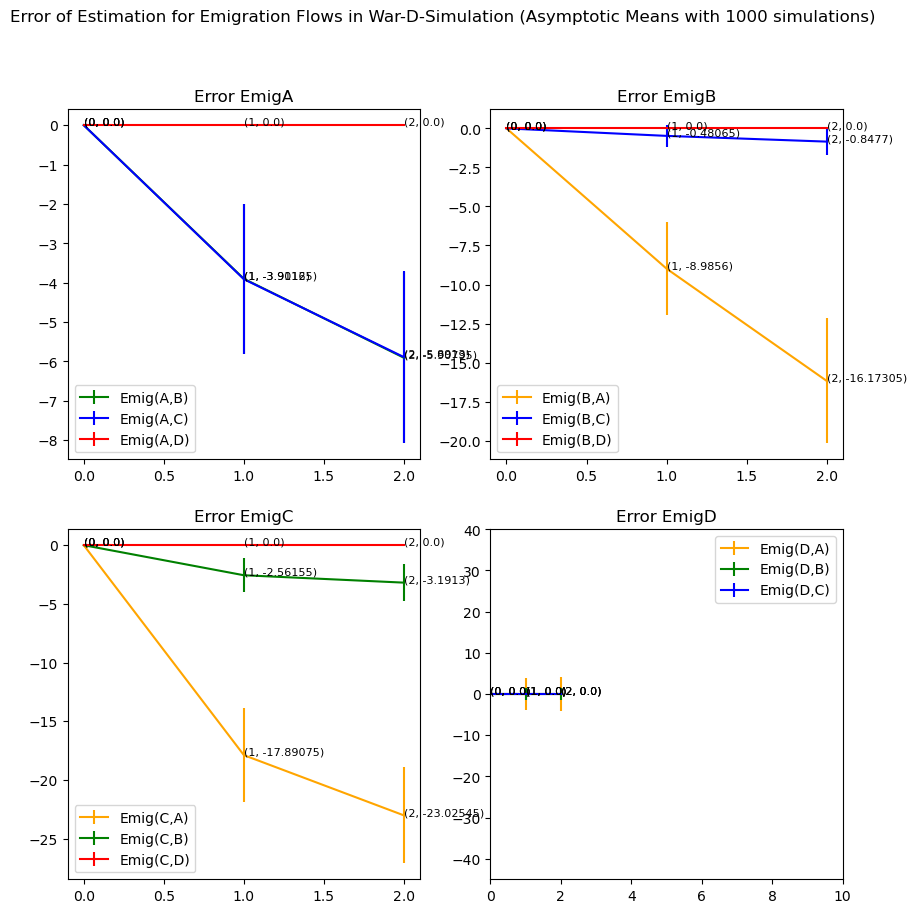

In [352]:
plt.rcParams["figure.figsize"] = [10, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
plt.ylim(-45, 40)
plt.xlim(0, 10)
text = ["orange","green", "blue", "red"]        
text2A = ["Stayer(A,A)","Emig(A,B)", "Emig(A,C)", "Emig(A,D)"]
for k in range(1,4):
    A = [Mean_TEEMt1[0][k], Mean_TEEMt2[0][k], Mean_TEEMt3[0][k]]
    B = [0, 1, 2]
    C = [np.sqrt(Var_EEMt1[0][k]), np.sqrt(Var_EEMt2[0][k]), np.sqrt(Var_EEMt3[0][k])]
    ax1.errorbar(B,A,yerr=C, color=text[k], label=text2A[k])
    ax1.legend()
    for x, y in zip(B,A):
        ax1.text(x, y, f"({x}, {y})", fontsize=8)
        
text2B = ["Emig(B,A)","Stayer(B,B)","Emig(B,C)", "Emig(B,D)"]
for k in [0,2,3]:
    A = [Mean_TEEMt1[1][k], Mean_TEEMt2[1][k], Mean_TEEMt3[1][k]]
    B = [0, 1, 2]
    C = [np.sqrt(Var_EEMt1[1][k]), np.sqrt(Var_EEMt2[1][k]), np.sqrt(Var_EEMt3[1][k])]
    ax2.errorbar(B,A, yerr=C, color=text[k], label=text2B[k])
    ax2.legend()
    for x, y in zip(B,A):
        ax2.text(x, y, f"({x}, {y})", fontsize=8)

text2C = ["Emig(C,A)", "Emig(C,B)","Stayer(C,C)", "Emig(C,D)"]     
for k in [0,1,3]:
    A = [Mean_TEEMt1[2][k], Mean_TEEMt2[2][k], Mean_TEEMt3[2][k]]
    B = [0, 1, 2]
    C = [np.sqrt(Var_EEMt1[2][k]), np.sqrt(Var_EEMt2[2][k]), np.sqrt(Var_EEMt3[2][k])]
    ax3.errorbar(B,A,yerr=C, label=text2C[k], color=text[k])
    ax3.legend()
    for x, y in zip(B,A):
        ax3.text(x, y, f"({x}, {y})", fontsize=8)
        
text2D = ["Emig(D,A)", "Emig(D,B)", "Emig(D,C)","Stayer(D,D)"]
for k in range(0,3):
    A = [Mean_TEEMt1[3][k], Mean_TEEMt2[3][k], Mean_TEEMt3[3][k]]
    B = [0, 1, 2]
    C = [np.sqrt(Var_EEMt1[2][k]), np.sqrt(Var_EEMt2[2][k]), np.sqrt(Var_EEMt3[2][k])]
    ax4.errorbar(B,A,yerr=C, color=text[k], label=text2D[k])
    ax4.legend(loc = "upper right")
    for x, y in zip(B,A):
        ax4.text(x, y, f"({x}, {y})", fontsize=8)
ax1.title.set_text('Error EmigA')
ax2.title.set_text('Error EmigB')
ax3.title.set_text('Error EmigC')
ax4.title.set_text('Error EmigD')
fig.suptitle("Error of Estimation for Emigration Flows in War-D-Simulation (Asymptotic Means with 1000 simulations)")
plt.show()

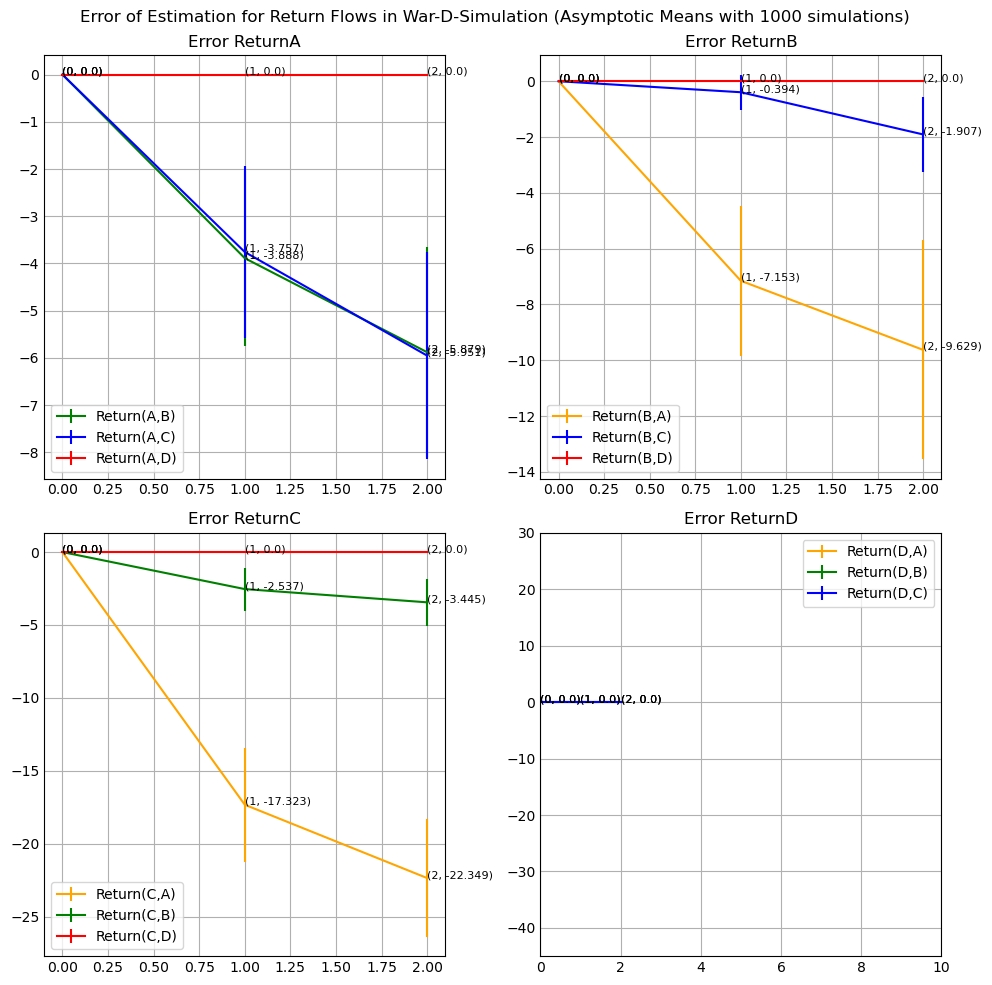

In [352]:
plt.rcParams["figure.figsize"] = [10, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
plt.ylim(-45, 30)
plt.xlim(0, 10)
text = ["orange","green", "blue", "red"]        
text2A = ["Stayer(A,A)","Return(A,B)", "Return(A,C)", "Return(A,D)"]

Var_ERt1
for k in range(1,4):
    A = [Mean_TERt1.T[0][k], Mean_TERt2.T[0][k], Mean_TERt3.T[0][k]]
    B = [0, 1, 2]
    C = [np.sqrt(Var_ERt1.T[0][k]), np.sqrt(Var_ERt2.T[0][k]), np.sqrt(Var_ERt3.T[0][k])]
    ax1.errorbar(B,A,yerr=C, color=text[k], label=text2A[k])
    ax1.legend()
    for x, y in zip(B,A):
        ax1.text(x, y, f"({x}, {y})", fontsize=8)
        
text2B = ["Return(B,A)","Stayer(B,B)","Return(B,C)", "Return(B,D)"]
for k in [0,2,3]:
    A = [Mean_TERt1.T[1][k], Mean_TERt2.T[1][k], Mean_TERt3.T[1][k]]
    B = [0, 1, 2]
    C = [np.sqrt(Var_ERt1.T[1][k]), np.sqrt(Var_ERt2.T[1][k]), np.sqrt(Var_ERt3.T[1][k])]
    ax2.errorbar(B,A,yerr=C, color=text[k], label=text2B[k])
    ax2.legend()
    for x, y in zip(B,A):
        ax2.text(x, y, f"({x}, {y})", fontsize=8)

text2C = ["Return(C,A)", "Return(C,B)","Stayer(C,C)", "Return(C,D)"]     
for k in [0,1,3]:
    A = [Mean_TERt1.T[2][k], Mean_TERt2.T[2][k], Mean_TERt3.T[2][k]]
    B = [0, 1, 2]
    C = [np.sqrt(Var_ERt1.T[2][k]), np.sqrt(Var_ERt2.T[2][k]), np.sqrt(Var_ERt3.T[2][k])]
    ax3.errorbar(B,A,yerr=C, label=text2C[k], color=text[k])
    ax3.legend()
    for x, y in zip(B,A):
        ax3.text(x, y, f"({x}, {y})", fontsize=8)
        
text2D = ["Return(D,A)", "Return(D,B)", "Return(D,C)","Stayer(D,D)"]
for k in range(0,3):
    A = [Mean_TERt1.T[3][k], Mean_TERt2.T[3][k], Mean_TERt3.T[3][k]]
    B = [0, 1, 2]
    C = [np.sqrt(Var_ERt1.T[3][k]), np.sqrt(Var_ERt2.T[3][k]), np.sqrt(Var_ERt3.T[3][k])]
    ax4.errorbar(B,A,yerr=C, color=text[k], label=text2D[k])
    ax4.legend(loc = "upper right")
    for x, y in zip(B,A):
        ax4.text(x, y, f"({x}, {y})", fontsize=8)
ax1.title.set_text('Error ReturnA')
ax2.title.set_text('Error ReturnB')
ax3.title.set_text('Error ReturnC')
ax4.title.set_text('Error ReturnD')
fig.suptitle("Error of Estimation for Return Flows in War-D-Simulation (Asymptotic Means with 1000 simulations)")
plt.show()

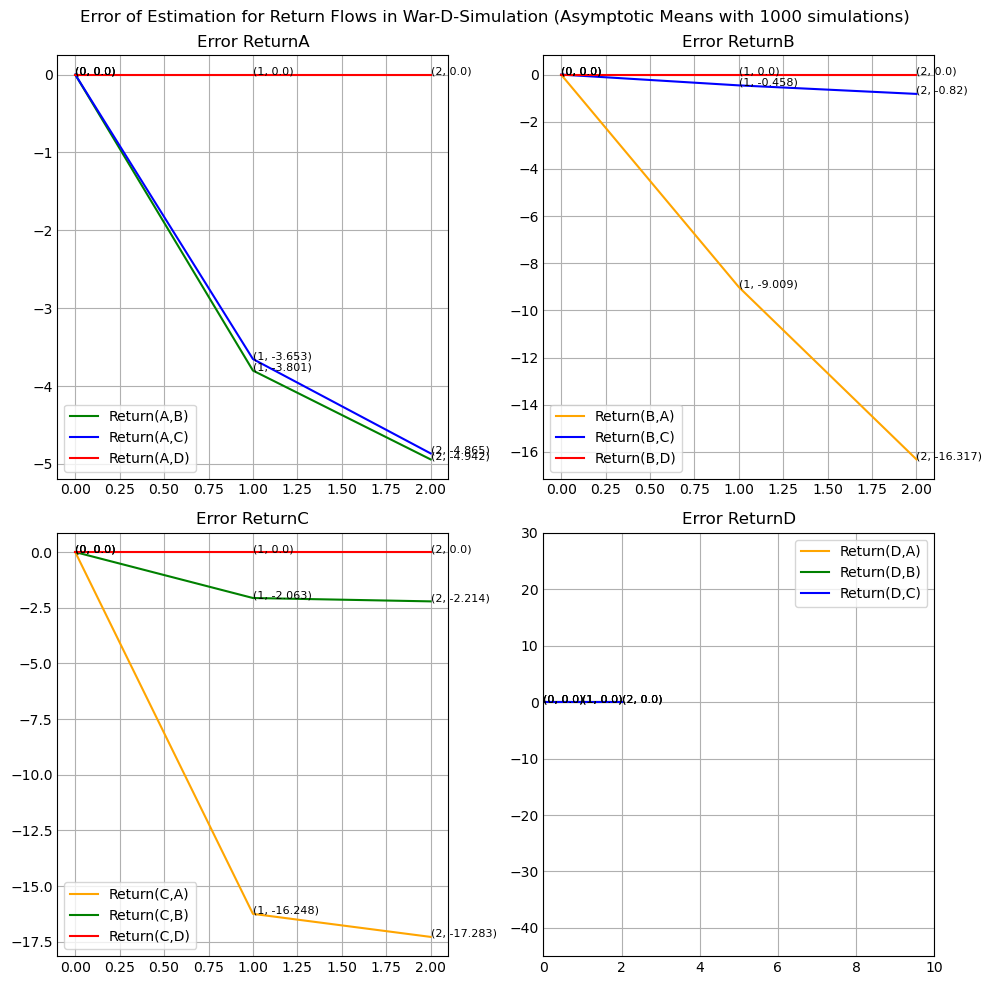

In [330]:
plt.rcParams["figure.figsize"] = [10, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
plt.ylim(-45, 30)
plt.xlim(0, 10)
text = ["orange","green", "blue", "red"]        
text2A = ["Stayer(A,A)","Return(A,B)", "Return(A,C)", "Return(A,D)"]

for k in range(1,4):
    A = [Mean_TAERt1.T[0][k], Mean_TAERt2.T[0][k], Mean_TAERt3.T[0][k]]
    B = [0, 1, 2]
    ax1.plot(B,A, color=text[k], label=text2A[k])
    ax1.legend()
    for x, y in zip(B,A):
        ax1.text(x, y, f"({x}, {y})", fontsize=8)
        
text2B = ["Return(B,A)","Stayer(B,B)","Return(B,C)", "Return(B,D)"]
for k in [0,2,3]:
    A = [Mean_TAERt1.T[1][k], Mean_TAERt2.T[1][k], Mean_TAERt3.T[1][k]]
    B = [0, 1, 2]
    ax2.plot(B,A, color=text[k], label=text2B[k])
    ax2.legend()
    for x, y in zip(B,A):
        ax2.text(x, y, f"({x}, {y})", fontsize=8)

text2C = ["Return(C,A)", "Return(C,B)","Stayer(C,C)", "Return(C,D)"]     
for k in [0,1,3]:
    A = [Mean_TAERt1.T[2][k], Mean_TAERt2.T[2][k], Mean_TAERt3.T[2][k]]
    B = [0, 1, 2]
    ax3.plot(B,A, label=text2C[k], color=text[k])
    ax3.legend()
    for x, y in zip(B,A):
        ax3.text(x, y, f"({x}, {y})", fontsize=8)
        
text2D = ["Return(D,A)", "Return(D,B)", "Return(D,C)","Stayer(D,D)"]
for k in range(0,3):
    A = [Mean_TAERt1.T[3][k], Mean_TAERt2.T[3][k], Mean_TAERt3.T[3][k]]
    B = [0, 1, 2]
    ax4.plot(B,A, color=text[k], label=text2D[k])
    ax4.legend(loc = "upper right")
    for x, y in zip(B,A):
        ax4.text(x, y, f"({x}, {y})", fontsize=8)
ax1.title.set_text('Error ReturnA')
ax2.title.set_text('Error ReturnB')
ax3.title.set_text('Error ReturnC')
ax4.title.set_text('Error ReturnD')
fig.suptitle("Error of Estimation for Return Flows in War-D-Simulation (Asymptotic Means with 1000 simulations)")
plt.show()

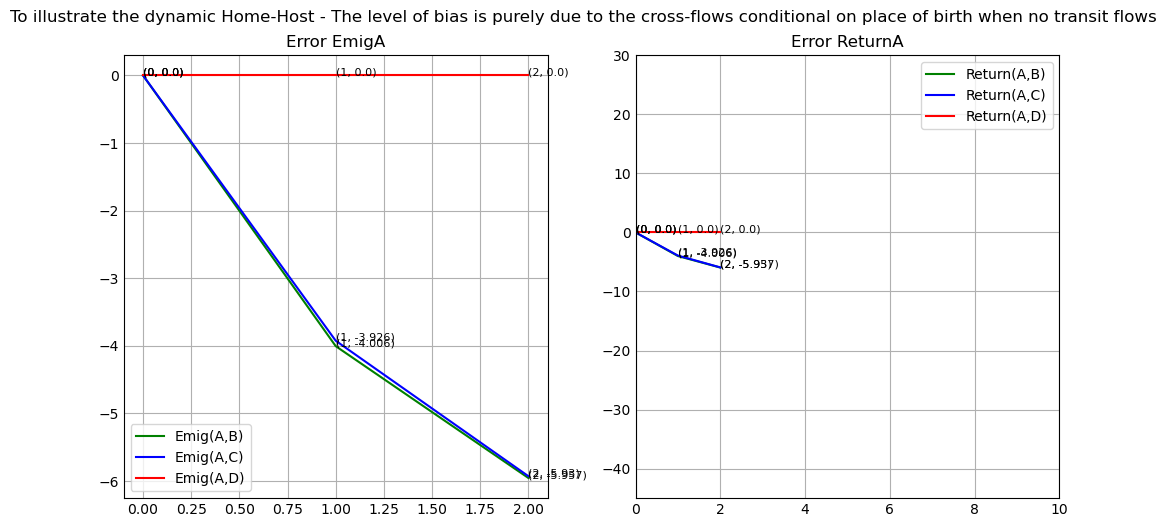

In [334]:
plt.rcParams["figure.figsize"] = [10, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
plt.ylim(-45, 30)
plt.xlim(0, 10)
text = ["orange","green", "blue", "red"]        
text2AR = ["Stayer(A,A)","Return(A,B)", "Return(A,C)", "Return(A,D)"]
text2AE = ["Stayer(A,A)","Emig(A,B)", "Emig(A,C)", "Emig(A,D)"]

for k in range(1,4):
    A = [Mean_TEEMt1[0][k], Mean_TEEMt2[0][k], Mean_TEEMt3[0][k]]
    B = [0, 1, 2]
    ax1.plot(B,A, color=text[k], label=text2AE[k])
    ax1.legend()
    for x, y in zip(B,A):
        ax1.text(x, y, f"({x}, {y})", fontsize=8)

for k in range(1,4):
    A = [Mean_TERt1.T[0][k], Mean_TERt2.T[0][k], Mean_TERt3.T[0][k]]
    B = [0, 1, 2]
    ax2.plot(B,A, color=text[k], label=text2AR[k])
    ax2.legend()
    for x, y in zip(B,A):
        ax2.text(x, y, f"({x}, {y})", fontsize=8)
        
ax1.title.set_text('Error EmigA')
ax2.title.set_text('Error ReturnA')
fig.suptitle("To illustrate the dynamic Home-Host - The level of bias is purely due to the cross-flows conditional on place of birth when no transit flows")
plt.show()